In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils.blr import BayesLinearRegressor, eenn_bayes_intervals
from avcs.regression import parallel_eenn_avcs_regression, running_intersection, marginal_coverage, consistency

from matplotlib.lines import Line2D
import utils.plotting_style

In [5]:
# Data params
Y_MIN = 0.
Y_MAX = 5.

# Model params
MODEL_TYPE = 'albert_large'

# Dataset
DATASET = 'sick'

# AVCS params
ALPHA = 0.05
S = 1

In [6]:
h_arr_test = torch.load(f'data/albert/{DATASET}/{MODEL_TYPE}/h_test.pt', map_location=torch.device('cpu'))
targets_test = torch.load(f'data/albert/{DATASET}/{MODEL_TYPE}/targets_test.pt', map_location=torch.device('cpu'))
preds_test = torch.load(f'data/albert/{DATASET}/{MODEL_TYPE}/logits_test.pt', map_location=torch.device('cpu'))
preds_test = preds_test.squeeze()

h_arr_dev = torch.load(f'data/albert/{DATASET}/{MODEL_TYPE}/h_dev.pt', map_location=torch.device('cpu'))
targets_dev = torch.load(f'data/albert/{DATASET}/{MODEL_TYPE}/targets_dev.pt', map_location=torch.device('cpu'))
preds_dev = torch.load(f'data/albert/{DATASET}/{MODEL_TYPE}/logits_dev.pt', map_location=torch.device('cpu'))
preds_dev = preds_dev.squeeze()

# c_test_qr = torch.load(f'data/albert/{DATASET}/{MODEL_TYPE}_qr/logits_test.pt', map_location=torch.device('cpu'))
# c_test_qr = c_test_qr.detach().numpy()
# c_test_qr = [list(map(tuple, c_test_qr[:, i, :])) for i in range(c_test_qr.shape[1])]

# c_dev_qr = torch.load(f'data/albert/{DATASET}/{MODEL_TYPE}_qr/logits_dev.pt', map_location=torch.device('cpu'))
# targets_dev_qr = torch.load(f'data/albert/{DATASET}/{MODEL_TYPE}_qr/targets_dev.pt', map_location=torch.device('cpu'))

L_test, N_test, H_test = h_arr_test.shape
L_dev, N_dev, H_dev = h_arr_dev.shape

In [7]:
# q_hats = []
# for l in range(L_dev):
#     cal_scores = np.maximum(targets_dev_qr - c_dev_qr[l, :, 1], c_dev_qr[l, :, 0] - targets_dev_qr)
#     q_hats.append(np.quantile(cal_scores, np.ceil((N_dev + 1) * (1 - ALPHA)) / N_dev, interpolation='higher'))

# c_test_cqr = []
# for i in range(len(c_test_qr)):
#     c_test_cqr.append([(c_test_qr[i][j][0] - q_hats[j], c_test_qr[i][j][1] + q_hats[j]) for j in range(len(c_test_qr[i]))])

In [8]:
BLRs = []
for l in range(L_test):
    BLR_d = BayesLinearRegressor(model=None)
    BLR_d.fit(h_arr_dev[l], targets_dev.reshape(-1, 1).numpy())
    print(BLR_d.sigma_likelihood)
    BLRs.append(BLR_d)

0.9695681590227112
0.6566650483865849
0.5832744200419887
0.5615730957421449
0.5020986279499013
0.47286554580027357
0.44919127884000765
0.43818939104789595
0.4284881746555082
0.4233577159135789
0.41812746072273915
0.41497628258463715
0.4096847587146793
0.4069675671760619
0.40633353638903524
0.40631562308019453
0.4050034829106593
0.4046064290235679
0.40455834295513704
0.4064675119506009
0.40672360647016675
0.4085581938862874
0.40750257227561115
0.4060808682518043


In [9]:
c_avcs, epistem_uncer, preds = parallel_eenn_avcs_regression(x_star=h_arr_test, BLR_models=BLRs, alpha=ALPHA, S=S)
c_avcs = [running_intersection(C) for C in c_avcs]
c_bayes = eenn_bayes_intervals(x_star=h_arr_test, BLR_models=BLRs)
c_bayes_intersect = [running_intersection(C) for C in c_bayes]

# c_qr = c_test_qr
# c_qr_intersect = [running_intersection(C) for C in c_qr]

# c_cqr = c_test_cqr
# c_cqr_intersect = [running_intersection(C) for C in c_cqr]

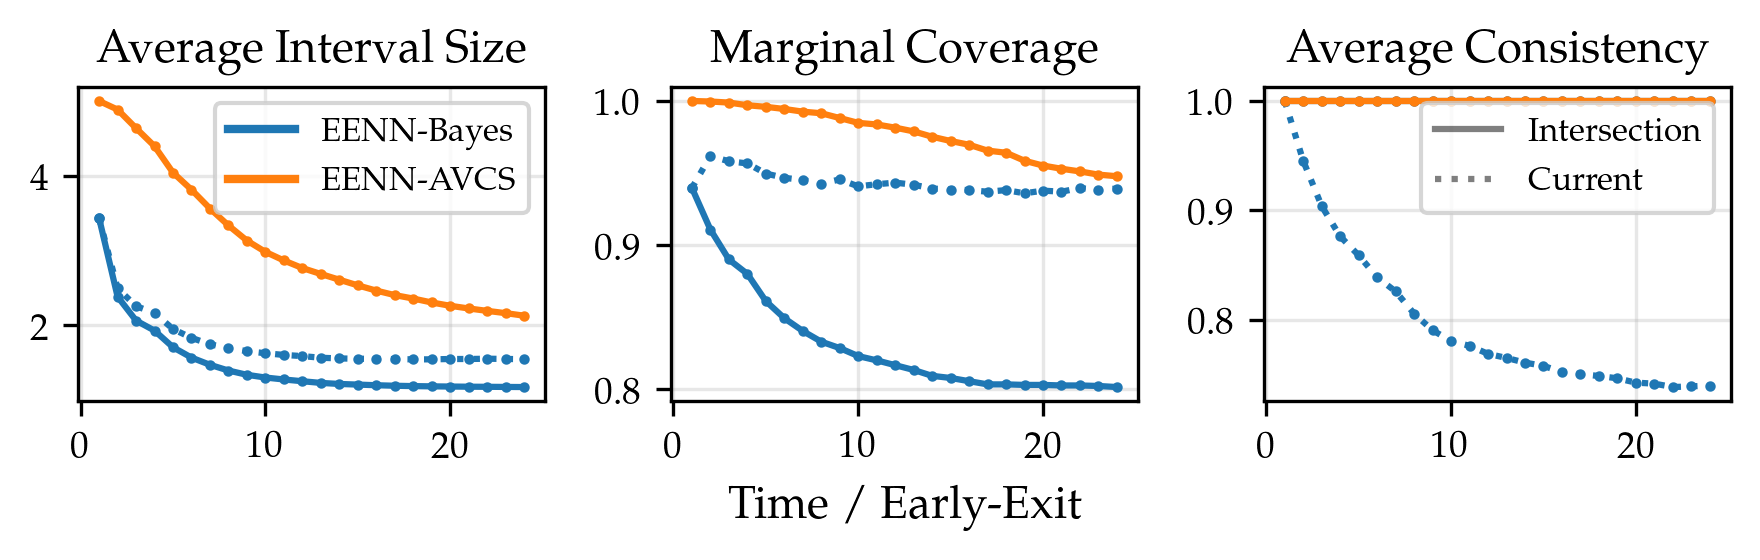

In [10]:
COLOR_DICT = {'AVCS': 'tab:orange', 'BLR': 'tab:blue', 
              'AVCS-intersect': 'tab:orange', 'BLR-intersect': 'tab:blue',
              'QR': 'tab:purple', 'QR-intersect': 'tab:purple',
              'CQR': 'tab:green', 'CQR-intersect': 'tab:green',}
LS_DICT = {'AVCS': 'dotted', 'BLR': 'dotted', 'AVCS-intersect': '-', 'BLR-intersect': '-', 'QR': 'dotted', 'QR-intersect': '-', 'CQR': 'dotted', 'CQR-intersect': '-',}
EXITS = [l + 1 for l in range(L_test)]
fig, ax = plt.subplots(1, 3, figsize=(6, 2))

LW = 1.5
MS = 1.5

for label, intervals in zip(['BLR', 'BLR-intersect', 
                             'AVCS-intersect', 
                             # 'QR', 'QR-intersect', 
                             # 'CQR', 'CQR-intersect'
                             ], 
                            [c_bayes, c_bayes_intersect, 
                             c_avcs, 
                             # c_qr, c_qr_intersect, 
                             # c_cqr, c_cqr_intersect
                             ]):

    clipped_sizes = np.mean([np.array([min(c[l][1], Y_MAX) - max(c[l][0], Y_MIN) for c in intervals]) for l in range(L_test)], axis=1)
    coverage = marginal_coverage(targets_test, intervals)
    consistency_arr = [1.] + list(np.mean(consistency(intervals), axis=0))
    
    for i, (plot_type, data) in enumerate(zip(['Average Interval Size', 'Marginal Coverage', 'Average Consistency'],
                               [clipped_sizes, coverage, consistency_arr])):
        
        ax[i].plot(EXITS, data, marker='o', color=COLOR_DICT[label], linestyle=LS_DICT[label], label=label, ms=MS, lw=LW)
        ax[i].set_title(plot_type)


ax[1].set_xlabel('Time / Early-Exit')


lines1 = [
    Line2D([0], [0], color='black', lw=LW, linestyle='-', alpha=0.5),
    Line2D([0], [0], color='black', lw=LW, linestyle='dotted', alpha=0.5),
]
labels1 = ["Intersection", 'Current']

lines2 = [
    Line2D([0], [0], color='tab:blue', lw=2, linestyle='-'),
    Line2D([0], [0], color='tab:orange', lw=2, linestyle='-'),
    # Line2D([0], [0], color='tab:purple', lw=2, linestyle='-'),
    Line2D([0], [0], color='tab:green', lw=2, linestyle='-'),

]
labels2 = [
    "EENN-Bayes",
    "EENN-AVCS",
    # "EENN-QR",
    # "CQR"
]

legend1 = ax[2].legend(lines1, labels1,  fontsize=8)
# legend2 = ax[0].legend(lines2, labels2, loc='lower left', fontsize=8)
legend2 = ax[0].legend(lines2, labels2, loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()